<a href="https://colab.research.google.com/github/RakinduM/AI-weather-forecast/blob/feat%2Ftrain-a-model-using-1D-CNN/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

--Load and clean the dataset &
Feature Engineering

In [8]:
df = pd.read_csv("weatherAUS_updated.csv")

# Convert Date
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Feature Engineering
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["Season"] = ((df["Month"] % 12 + 3) // 3)

# Handle RainToday BEFORE encoding to prevent NaN issues
if "RainToday" in df.columns:
    # Fill missing values in RainToday first
    df["RainToday"] = df["RainToday"].fillna("No")
    df["RainToday"] = df["RainToday"].map({"Yes": 1, "No": 0})
else:
    df["RainToday"] = 0

# Fill missing numerical features with median
numerical_cols_to_fill = [col for col in df.select_dtypes(include=["float64", "int64"]).columns if col != "RainTomorrow"]
for col in numerical_cols_to_fill:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Fill missing categorical features with "Missing"
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].fillna("Missing")

# Choose Features
numeric_features = [
    'MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine',
    'WindGustSpeed','WindSpeed9am','WindSpeed3pm',
    'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
    'Temp9am','Temp3pm', 'RainToday'
]

categorical_features = ['Location','WindGustDir','WindDir9am','WindDir3pm','Season','Month','DayOfWeek']

all_features = numeric_features + categorical_features + ["RainTomorrow"]
df = df[[col for col in all_features if col in df.columns]]

# Encode Categorical Columns
le = LabelEncoder()
for col in categorical_features:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# Handle target column
if "RainTomorrow" in df.columns:
    if df["RainTomorrow"].dtype == object:
        df["RainTomorrow"] = df["RainTomorrow"].astype(str).str.strip().str.title()
        df = df[df["RainTomorrow"].isin(["Yes", "No"])].copy()
        df["RainTomorrow"] = df["RainTomorrow"].map({"Yes": 1, "No": 0})
    else:
        df = df.dropna(subset=["RainTomorrow"])
        df["RainTomorrow"] = df["RainTomorrow"].astype(int)
else:
    raise ValueError("RainTomorrow column not found in the dataset.")

print("NaN values in RainTomorrow:", df["RainTomorrow"].isna().sum())
print("Target distribution:\n", df["RainTomorrow"].value_counts())

#Check for NaN/Inf in features
print("\n=== Checking for problematic values in features ===")
X_temp = df.drop("RainTomorrow", axis=1)
nan_counts = X_temp.isnull().sum()
inf_counts = np.isinf(X_temp.select_dtypes(include=[np.number])).sum()

if nan_counts.sum() > 0:
    print("WARNING: NaN values found in features:")
    print(nan_counts[nan_counts > 0])
    # Drop rows with any NaN values
    df = df.dropna()
    print(f"Dropped rows with NaN. New shape: {df.shape}")

if inf_counts.sum() > 0:
    print("WARNING: Infinite values found in features:")
    print(inf_counts[inf_counts > 0])
    # Replace infinite values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"Dropped rows with Inf. New shape: {df.shape}")

# Split Data
X = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]

print("\nFinal dataset shape:", X.shape)
print("Target value counts:\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling with additional safety checks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle potential NaN or infinite values after scaling
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=1e10, neginf=-1e10)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=1e10, neginf=-1e10)

# Verify no NaN/Inf remain
print("\nPost-scaling check:")
print(f"NaN in train: {np.isnan(X_train_scaled).sum()}")
print(f"Inf in train: {np.isinf(X_train_scaled).sum()}")
print(f"NaN in test: {np.isnan(X_test_scaled).sum()}")
print(f"Inf in test: {np.isinf(X_test_scaled).sum()}")

# Reshape to 3D for Conv1D: (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

NaN values in RainTomorrow: 0
Target distribution:
 RainTomorrow
0    110316
1    110316
Name: count, dtype: int64

=== Checking for problematic values in features ===

Final dataset shape: (220632, 22)
Target value counts:
 RainTomorrow
0    110316
1    110316
Name: count, dtype: int64

Post-scaling check:
NaN in train: 0
Inf in train: 0
NaN in test: 0
Inf in test: 0


Build and Train the model

In [9]:
def build_cnn1d(num_features):
    model = keras.Sequential([
        layers.Input(shape=(num_features, 1)),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.AUC(name='auc')])
    return model

cnn_model = build_cnn1d(num_features=X_train_cnn.shape[1])
cnn_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7494 - auc: 0.8278 - loss: 0.5080 - val_accuracy: 0.7822 - val_auc: 0.8692 - val_loss: 0.4516
Epoch 2/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7795 - auc: 0.8622 - loss: 0.4636 - val_accuracy: 0.7881 - val_auc: 0.8742 - val_loss: 0.4429
Epoch 3/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7845 - auc: 0.8681 - loss: 0.4541 - val_accuracy: 0.7907 - val_auc: 0.8776 - val_loss: 0.4395
Epoch 4/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7868 - auc: 0.8697 - loss: 0.4515 - val_accuracy: 0.7943 - val_auc: 0.8813 - val_loss: 0.4329
Epoch 5/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7911 - auc: 0.8742 - loss: 0.4442 - val_accuracy: 0.7971 - val_auc: 0.8838 - val_loss: 0.4280
Epoch 6/30
2207/2207 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7947 - auc: 0.8784 - loss: 0.4370 - val_accuracy: 0.8005 - val_auc: 0.8872 - val_loss: 0.4215
Epoch 7/30
2207/2207 ━

Evaluation and Visualization

1379/1379 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Prediction check:
NaN in predictions: 0
Prediction range: [0.0000, 1.0000]

=== CNN Evaluation Metrics ===
Accuracy:  0.8258
Precision: 0.8234
Recall:    0.8297
F1 Score:  0.8265
AUC:       0.9105

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     22064
           1       0.82      0.83      0.83     22063

    accuracy                           0.83     44127
   macro avg       0.83      0.83      0.83     44127
weighted avg       0.83      0.83      0.83     44127



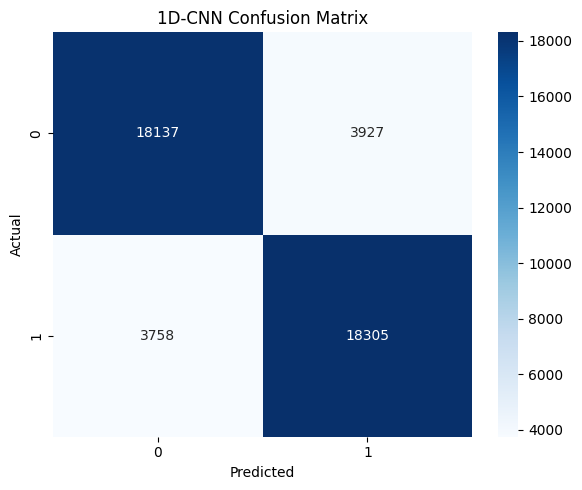

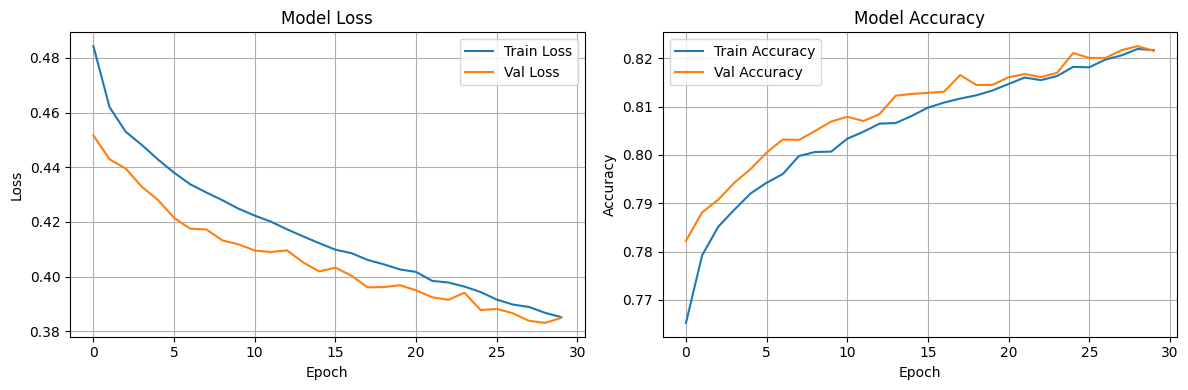

In [10]:
# Evaluate Model
y_pred_proba = cnn_model.predict(X_test_cnn).ravel()

# Additional safety check for predictions
print(f"\nPrediction check:")
print(f"NaN in predictions: {np.isnan(y_pred_proba).sum()}")
print(f"Prediction range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")

# Replace any NaN predictions with 0.5 (neutral probability)
y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.5)

y_pred = (y_pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba)

print("\n=== CNN Evaluation Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("1D-CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history_cnn.history['loss'], label='Train Loss')
ax1.plot(history_cnn.history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history_cnn.history['accuracy'], label='Train Accuracy')
ax2.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()